# Estudo Comparativo de Modelos de Séries Temporais Nebulosas

[<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">](https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode)


### Programa de Pós Graduação em Engenharia Elétrica - PPGEE
### Disciplina de Sistemas Nebulosos

Professor: André Paim Lemos

Autores: Leonardo Ferreira (leauferreira@gmail.com) e Petrônio Silva (petronio.candido@gmail.com)

* [Revisão De Literatura](https://www.overleaf.com/read/rqqctmpzgsnt)
* [Apresentação](https://www.overleaf.com/read/tdwskgrscknv)


## Índice

1. [Importações Comuns](#Importações-Comuns)
2. [Dados de Treinamento e Validação](#Dados-de-Treinamento-e-Validação)
   1. [University Of Alabama Enrollments](#University-Of-Alabama-Enrollments)
   2. [TAIEX - Taiwan Stock Exchange Index](#TAIEX---Taiwan-Stock-Exchange-Index)
3. [Códigos Comuns](#Códigos-Comuns)
   1. [Funções de Pertinência](#Funções-de-Pertinência)
   2. [Conjuntos Nebulosos](#Conjuntos-Nebulosos)
   3. [Particionadores do Universo de Discurso](#Particionadores-do-Universo-de-Discurso)
2. [First Order Fuzzy Time Series](#First-Order-Fuzzy-Time-Series)
   1. [FTS - Código Fonte](#FTS---Código-Fonte)
   2. [FTS - Experimento com o dataset Enrollments](#FTS---Experimento-com-o-dataset-Enrollments)
   3. [FTS - Experimento com o dataset TAIEX](#FTS---Experimento-com-o-dataset-TAIEX)
3. [Weighted Fuzzy Time Series](#Weighted-Fuzzy-Time-Series)
   1. [WFTS - Código Fonte](#WFTS---Código-Fonte)
   2. [WFTS - Experimento com o dataset Enrollments](#WFTS---Experimento-com-o-dataset-Enrollments)
   3. [WFTS - Experimento com o dataset TAIEX](#WFTS---Experimento-com-o-dataset-TAIEX)
4. [Improved Weighted Fuzzy Time Series](#Improved-Weighted-Fuzzy-Time-Series)
   1. [IWFTS - Código Fonte](#IWFTS---Código-Fonte)
   2. [IWFTS - Experimento com o dataset Enrollments](#IWFTS---Experimento-com-o-dataset-Enrollments)
   3. [IWFTS - Experimento com o dataset TAIEX](#IWFTS---Experimento-com-o-dataset-TAIEX)
5. [Exponentially Weighted Fuzzy Time Series](#Exponentially-Weighted-Fuzzy-Time-Series)
   1. [EWFTS - Código Fonte](#EWFTS---Código-Fonte)
   2. [EWFTS - Experimento com o dataset Enrollments](#EWFTS---Experimento-com-o-dataset-Enrollments)
   3. [EWFTS - Experimento com o dataset TAIEX](#EWFTS---Experimento-com-o-dataset-TAIEX)
6. [High Order Fuzzy Time Series](#High-Order-Fuzzy-Time-Series)
7. [Comparação entre os modelos]()
8. [Referências](#References)

# Importações Comuns

In [113]:
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Dados de Treinamento e Validação

### Função de Série Diferencial
A função de diferença serve para gerar um dataset que, ao invés do valor $F(t)$ original da série, terá a diferença entre dois valores consecutivos ou seja $\Delta F(t) = F(t-1) - F(t)$. O primeiro valor da série de diferenças é sempre considerado $0$.

Nesse tipo de série, o universo de discurso é dado por $U = [\min(\Delta F(t)),\max(\Delta F(t))]$ 

In [7]:
def diferencas(original):
    n = len(original)
    diff = [ original[t-1]-original[t] for t in range(1,n) ]
    diff.insert(0,0)
    return diff

### University Of Alabama Enrollments

O dataset abaixo foi retirado do artigo \cite{song1993fuzzy}

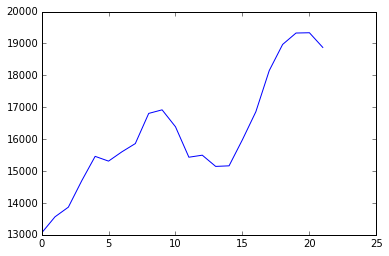

In [8]:
enrollments = pd.read_csv("DataSets/Enrollments.csv", sep=";")
enrollments = enrollments["Enrollments"]
plot(enrollments)

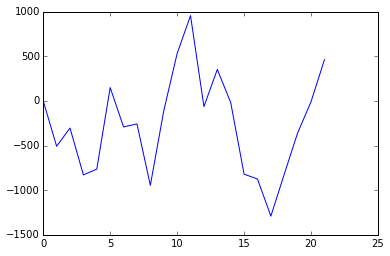

In [9]:
plot(diferencas(enrollments))

### TAIEX - Taiwan Stock Exchange Index

O dataset foi provido por \cite{taiex2015}

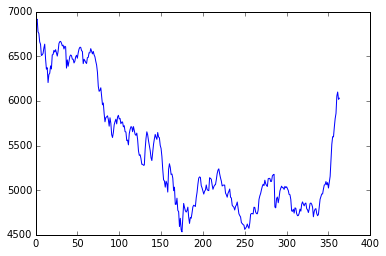

In [10]:
taiex = pd.read_csv("DataSets/TAIEX.csv", sep=",")
taiexsample = np.array(taiex["avg"][1:365])
plot(taiexsample)

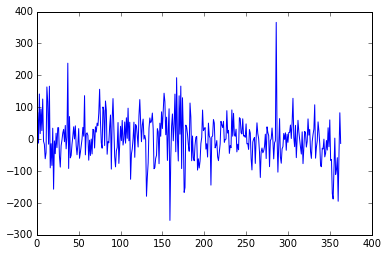

In [11]:
plot(diferencas(taiexsample))
#np.array(taiexsample)

# Códigos Comuns

### Funções de Pertinência

In [12]:
def trimf(x,parameters):
	if(x < parameters[0]):
		return 0
	elif(x >= parameters[0] and x < parameters[1]):
		return (x-parameters[0])/(parameters[1]-parameters[0])
	elif(x >= parameters[1] and x <= parameters[2]):
		return (parameters[2]-x)/(parameters[2]-parameters[1])
	else: 
		return 0

def trapmf(x, parameters):
		if(x < parameters[0]):
			return 0
		elif(x >= parameters[0] and x < parameters[1]):
			return (x-parameters[0])/(parameters[1]-parameters[0])
		elif(x >= parameters[1] and x <= parameters[2]):
			return 1
		elif(x >= parameters[2] and x <= parameters[3]):
			return (parameters[3]-x)/(parameters[3]-parameters[2])
		else: 
			return 0

def gaussmf(x,parameters):
		return math.exp(-0.5*((x-parameters[0]) / parameters[1] )**2)


def bellmf(x,parameters):
		return 1 / (1 + abs((xx - parameters[2])/parameters[0])**(2*parameters[1]))


def sigmf(x,parameters):
		return 1 / (1 + math.exp(-parameters[0] * (x - parameters[1])))


### Conjuntos Nebulosos

In [13]:
class FuzzySet:

	def __init__(self,name,mf,parameters,centroid):
		self.name = name
		self.mf = mf
		self.parameters = parameters
		self.centroid = centroid
        
	def membership(self,x):
		return self.mf(x,self.parameters)
    
	def __str__(self):
		return self.name + ": " + str(self.mf) + "(" + str(self.parameters) + ")"
    
    

### Particionadores do Universo de Discurso

In [14]:
def GridPartitionerTrimf(data,npart,names = None,prefix = "A"):
	sets = []
	dmax = max(data)
	dmin = min(data)
	dlen = dmax - dmin
	partlen = dlen / npart
	partition = dmin
	for c in range(npart):
		sets.append( FuzzySet(prefix+str(c),trimf,[partition-partlen, partition, partition+partlen], partition ) )
		partition = partition + partlen
		
	return sets

In [15]:
sts = GridPartitionerTrimf(enrollments,10)
for s in sts:
    print(s)

A0: <function trimf at 0xab196e84>([12426.799999999999, 13055, 13683.200000000001])
A1: <function trimf at 0xab196e84>([13055.0, 13683.200000000001, 14311.400000000001])
A2: <function trimf at 0xab196e84>([13683.200000000001, 14311.400000000001, 14939.600000000002])
A3: <function trimf at 0xab196e84>([14311.400000000001, 14939.600000000002, 15567.800000000003])
A4: <function trimf at 0xab196e84>([14939.600000000002, 15567.800000000003, 16196.000000000004])
A5: <function trimf at 0xab196e84>([15567.800000000003, 16196.000000000004, 16824.200000000004])
A6: <function trimf at 0xab196e84>([16196.000000000004, 16824.200000000004, 17452.400000000005])
A7: <function trimf at 0xab196e84>([16824.200000000004, 17452.400000000005, 18080.600000000006])
A8: <function trimf at 0xab196e84>([17452.400000000005, 18080.600000000006, 18708.800000000007])
A9: <function trimf at 0xab196e84>([18080.600000000006, 18708.800000000007, 19337.000000000007])


In [16]:
class FTS:
	def __init__(self,order,name):
		self.sets = {}
		self.flrgs = {}
		self.order = order
		self.name = name
        
	def fuzzy(self,data):
		best = {"fuzzyset":"", "membership":0.0}

		for f in self.sets:
			fset = self.sets[f]
			if best["membership"] <= fset.membership(data):
				best["fuzzyset"] = fset.name
				best["membership"] = fset.membership(data)

		return best

	def defuzzy(self,data):
		pass

	def learn(self, data, sets):
		pass  

	def predict(self,data):
		return self.defuzzy(data)

	def predictDiff(self,data,t):
		return data[t] + self.defuzzy(data[t-1]-data[t])

	def __str__(self):
		tmp = self.name + ":\n"
		for r in self.flrgs.keys():
			tmp = tmp + str(self.flrgs[r]) + "\n"
		return tmp


### Funções Auxiliares

In [17]:
def rmse(predictions,targets):
    return np.sqrt(np.mean((predictions-targets)**2))
    

In [18]:
def plotComparedSeries(original,fts,title):
	fig = plt.figure(figsize=[20,6])
	ax = fig.add_subplot(111)
	predicted = [fts.predict(xx) for xx in original]
	error = rmse(original,predicted)
	ax.plot(original,color='b',label="Original")
	ax.plot(predicted,color='r',label="Predicted")
	handles0, labels0 = ax.get_legend_handles_labels()
	ax.legend(handles0,labels0)
	ax.set_title(title)
	ax.set_ylabel('F(T)')
	ax.set_xlabel('T')
	ax.set_xlim([0,len(original)])
	ax.set_ylim([min(original),max(original)])

In [50]:
def plotCompared(original,predicted,labels,title):
	fig = plt.figure(figsize=[20,6])
	ax = fig.add_subplot(111)
	ax.plot(original,color='k',label="Original")
	for c in range(0,len(predicted)):
		ax.plot(predicted[c],label=labels[c])
	handles0, labels0 = ax.get_legend_handles_labels()
	ax.legend(handles0,labels0)
	ax.set_title(title)
	ax.set_ylabel('F(T)')
	ax.set_xlabel('T')
	ax.set_xlim([0,len(original)])
	ax.set_ylim([min(original),max(original)])

In [51]:
def SelecaoSimples_MenorRMSE(original,parameters,modelo):
	ret = []
	errors = []
	predicted_best = []
	print("Série Original")
	fig = plt.figure(figsize=[20,12])
	fig.suptitle("Comparação de modelos ")
	ax0 = fig.add_axes([0, 0.5, 0.65, 0.45]) #left, bottom, width, height
	ax0.set_xlim([0,len(original)])
	ax0.set_ylim([min(original),max(original)])
	ax0.set_title('Série Temporal')
	ax0.set_ylabel('F(T)')
	ax0.set_xlabel('T')
	ax0.plot(original,label="Original")
	min_rmse = 100000.0
	best = None
	for p in parameters:
		sets = GridPartitionerTrimf(original,p)
		fts = modelo(str(p)+ " particoes")
		fts.learn(original,sets)
		predicted = [fts.predict(xx) for xx in original]
		ax0.plot(predicted,label=fts.name)
		error = rmse(np.array(predicted),np.array(original))
		print(p,error)
		errors.append(error)
		if error < min_rmse:
			min_rmse = error
			best = fts
			predicted_best = predicted
	handles0, labels0 = ax0.get_legend_handles_labels()
	ax0.legend(handles0, labels0)
	ax1 = fig.add_axes([0.7, 0.5, 0.3, 0.45]) #left, bottom, width, height
	ax1.set_title('Comparação dos Erros Quadráticos Médios')
	ax1.set_ylabel('RMSE')
	ax1.set_xlabel('Quantidade de Partições')
	ax1.set_xlim([min(parameters),max(parameters)])
	ax1.plot(parameters,errors)
	ret.append(best)
	ret.append(predicted_best)
    # Modelo diferencial
	print("\nSérie Diferencial")
	errors = []
	predictedd_best = []
	ax2 = fig.add_axes([0, 0, 0.65, 0.45]) #left, bottom, width, height
	ax2.set_xlim([0,len(original)])
	ax2.set_ylim([min(original),max(original)])
	ax2.set_title('Série Temporal')
	ax2.set_ylabel('F(T)')
	ax2.set_xlabel('T')
	ax2.plot(original,label="Original")
	min_rmse = 100000.0
	bestd = None
	for p in parameters:
		sets = GridPartitionerTrimf(diferencas(original),p)
		fts = modelo(str(p)+ " particoes")
		fts.learn(diferencas(original),sets)
		predicted = [fts.predictDiff(original, xx) for xx in range(1,len(original))]
		predicted.insert(0,original[0])
		ax2.plot(predicted,label=fts.name)
		error = rmse(np.array(predicted),np.array(original))
		print(p,error)
		errors.append(error)
		if error < min_rmse:
			min_rmse = error
			bestd = fts
			predictedd_best = predicted
	handles0, labels0 = ax2.get_legend_handles_labels()
	ax2.legend(handles0, labels0)
	ax3 = fig.add_axes([0.7, 0, 0.3, 0.45]) #left, bottom, width, height
	ax3.set_title('Comparação dos Erros Quadráticos Médios')
	ax3.set_ylabel('RMSE')
	ax3.set_xlabel('Quantidade de Partições')
	ax3.set_xlim([min(parameters),max(parameters)])
	ax3.plot(parameters,errors)
	ret.append(bestd)
	ret.append(predictedd_best)
	return ret

# First Order Fuzzy Time Series

Os trabalhos pioneiros em séries temporais nebulosas são de \cite{song1993fuzzy} e a evolução apresentada por \cite{chen1996forecasting}. Nesses trabalhos define-se que o modelo de primeira ordem (\textit{First Order Fuzzy Time Series}) caracteriza-se por presumir que $F(t)$ é determinado unicamente por $F(t-1)$ ( ou $F(t-2)$ ou ... ou $F(t-m)$ ).

## FTS - Código Fonte

In [52]:
class FirstOrderFLRG:
	def __init__(self,premiss):
		self.premiss = premiss
		self.consequent = set()
	
	def append(self,c):
		self.consequent.add(c)

	def __str__(self):
		tmp = self.premiss + " -> "
		tmp2 = ""
		for c in self.consequent:
			if len(tmp2) > 0:
				tmp2 = tmp2 + ","
			tmp2 = tmp2 + c
		return tmp + tmp2


In [53]:
class FirstOrderFTS(FTS):
	def __init__(self,name):
		super(FirstOrderFTS, self).__init__(1,name)
        
	def defuzzy(self,data):
        
		actual = self.fuzzy(data)
        
		if actual["fuzzyset"] not in self.flrgs:
			return self.sets[actual["fuzzyset"]].centroid

		flrg = self.flrgs[actual["fuzzyset"]]

		count = 0.0
		denom = 0.0

		for s in flrg.consequent:
			denom = denom + self.sets[s].centroid
			count = count + 1.0

		return denom/count
        
	def learn(self, data, sets):
		last = {"fuzzyset":"", "membership":0.0}
		actual = {"fuzzyset":"", "membership":0.0}
		
		for s in sets:
			self.sets[s.name] = s
		
		self.flrgs = {}
		count = 1
		for inst in data:
			actual = self.fuzzy(inst)
			
			if count > self.order:
				if last["fuzzyset"] not in self.flrgs:
					self.flrgs[last["fuzzyset"]] = FirstOrderFLRG(last["fuzzyset"])
			
				self.flrgs[last["fuzzyset"]].append(actual["fuzzyset"])    
			count = count + 1
			last = actual
        

## FTS - Experimento com o dataset Enrollments

Série Original
4 1196.72914433
8 1489.85136323
10 435.391975956
20 521.825771059
30 504.555710502

Série Diferencial
4 323.947118826
8 462.123024346
10 385.15987482
20 538.41592757
30 557.037044313


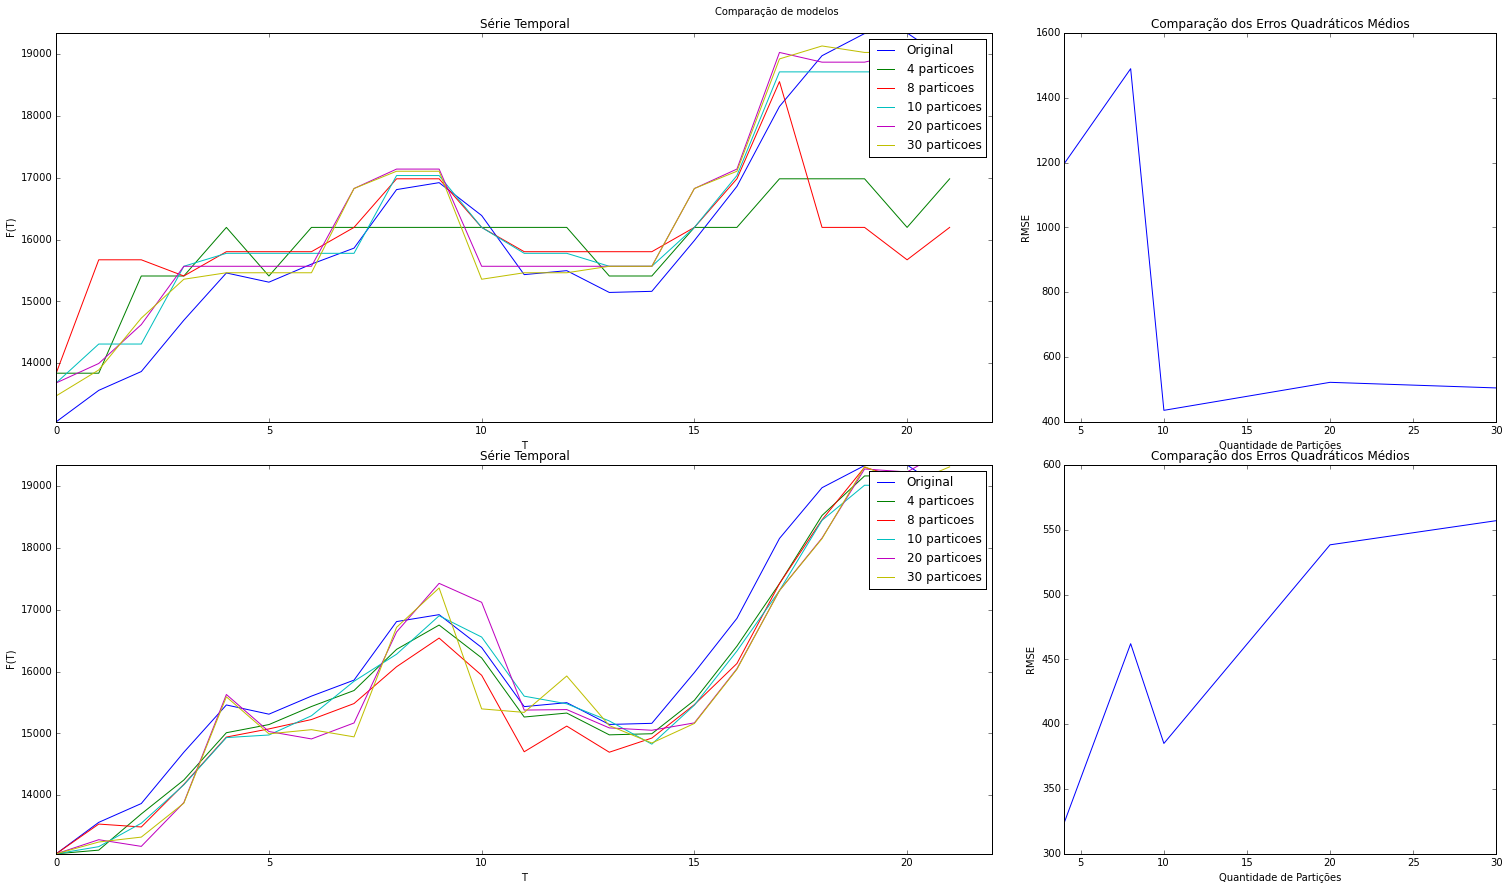

In [54]:
fts1,fts1p,ftsd1,ftsd1p = SelecaoSimples_MenorRMSE(enrollments,[4,8, 10,20, 30],FirstOrderFTS)

In [303]:
print(fts1)

10 particoes:
A5 -> A4,A6
A0 -> A1
A3 -> A4,A3,A5
A6 -> A8,A5,A6
A9 -> A9
A8 -> A9
A4 -> A4,A3,A6
A1 -> A3,A1



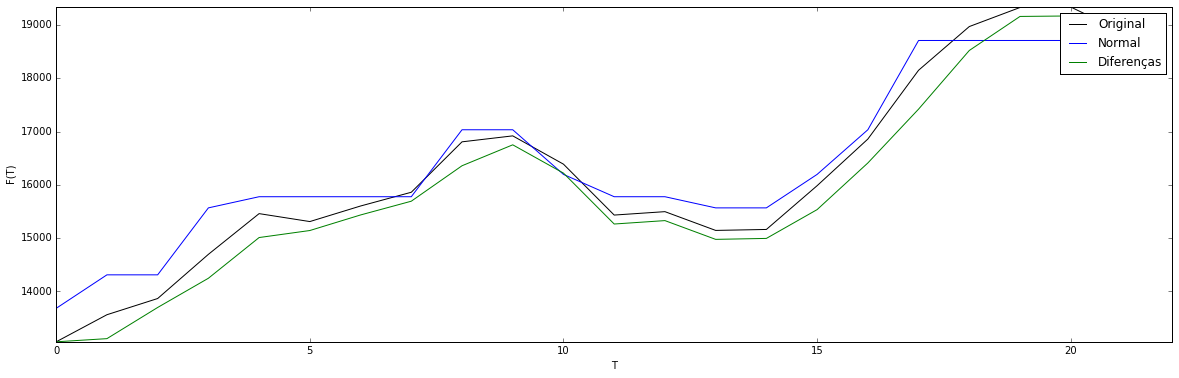

In [55]:
plotCompared(enrollments,[fts1p,ftsd1p],["Normal","Diferenças"],'')

## FTS - Experimento com o dataset TAIEX

Série Original
10 76.2322839423
15 202.275084286
20 64.1396258604
25 47.2639320704
30 158.100188364
35 157.614674027

Série Diferencial
10 27.2413048178
15 29.1038362377
20 35.3496996781
25 32.197951632
30 26.0762576105
35 31.6078910719


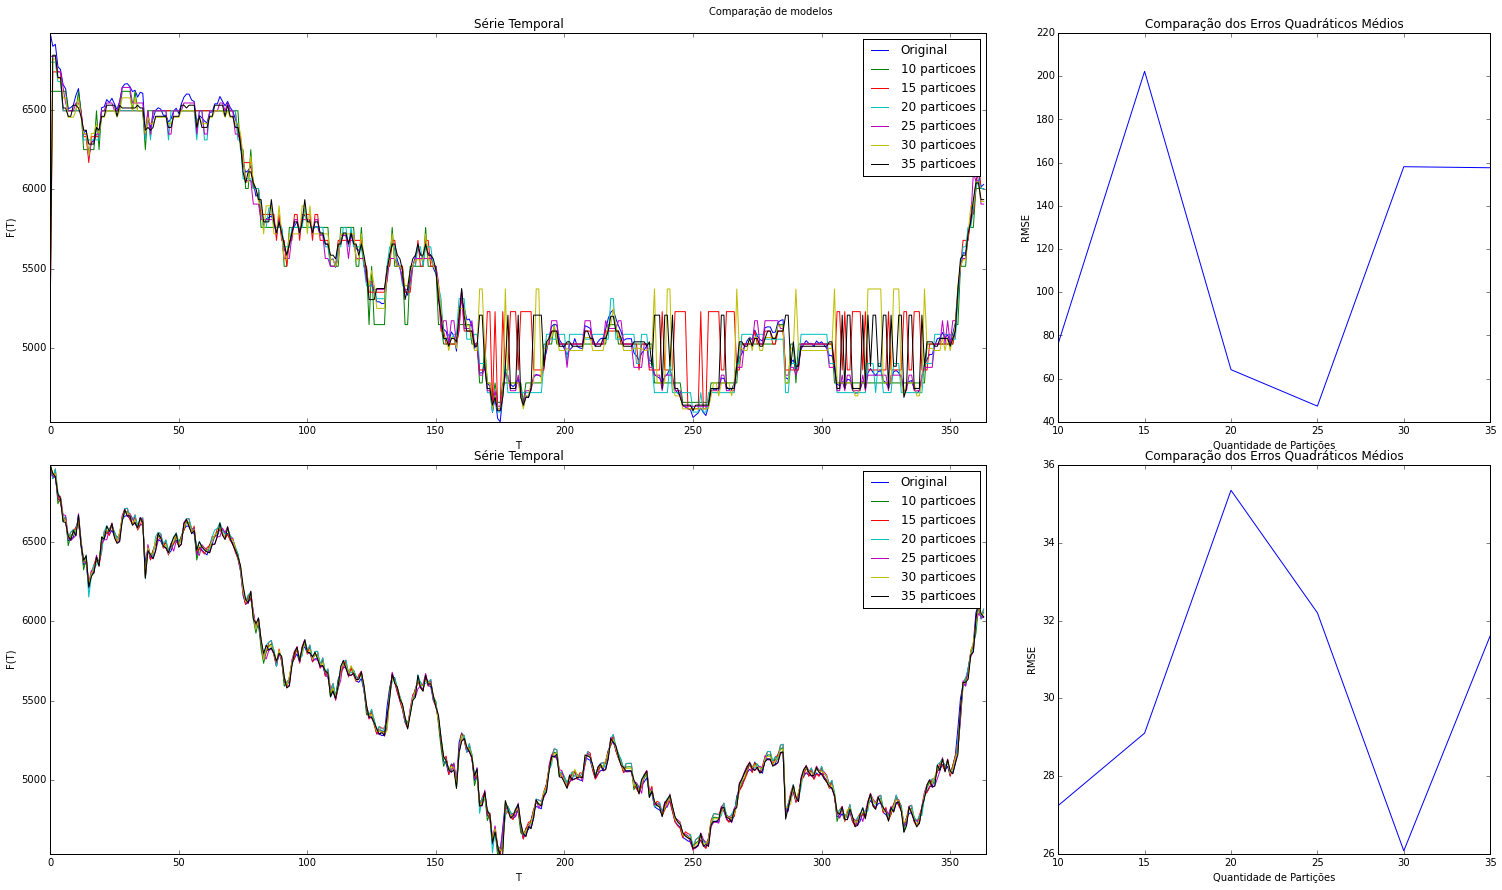

In [56]:
fts2,fts2p,ftsd2,ftsd2p= SelecaoSimples_MenorRMSE(taiexsample,[10,15,20,25,30,35],FirstOrderFTS)

In [310]:
print(fts2)

25 particoes:
A4 -> A5,A4,A2,A3
A22 -> A22,A21
A9 -> A8,A11,A10,A7,A9
A21 -> A22,A19,A21,A20
A14 -> A16
A5 -> A5,A3,A6,A7,A4
A16 -> A16,A15
A6 -> A8,A5,A6,A7
A13 -> A14,A12,A13
A8 -> A8,A10,A7,A9
A24 -> A23,A24
A11 -> A12,A11,A10,A9
A0 -> A0,A2,A1
A12 -> A12,A11,A13
A20 -> A19,A21,A20
A10 -> A11,A10,A9
A2 -> A0,A3,A2,A1,A4
A17 -> A16,A18
A3 -> A4,A3,A2
A7 -> A8,A3,A6,A7
A19 -> A17,A19,A20,A18
A23 -> A23,A22
A18 -> A17,A19,A18
A1 -> A0,A2,A1
A15 -> A15,A13



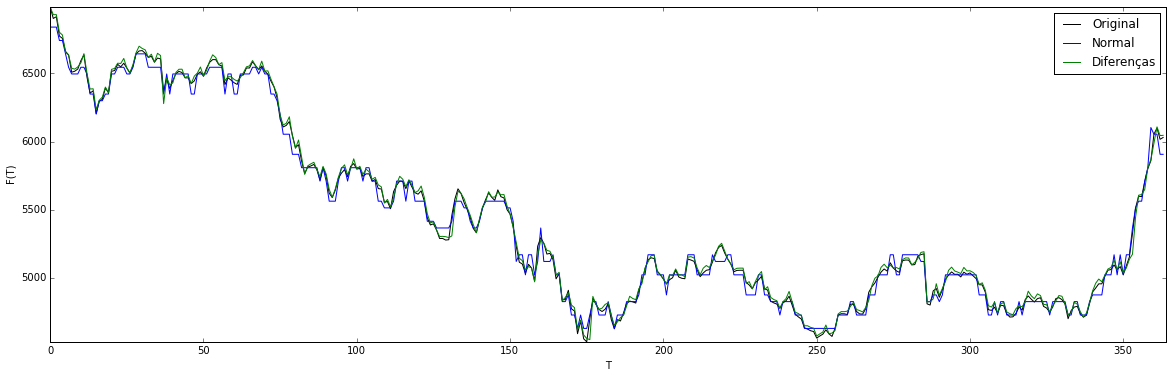

In [58]:
plotCompared(taiexsample,[fts2p,ftsd2p],["Normal","Diferenças"],'')

# Weighted Fuzzy Time Series

O trabalho de \cite{yu2005weighted} propõe um modelo  - as \textit{Weighted Fuzzy Time Series} -  em que os grupos de regras permitem repetições no consequente e tenham ponderação monotonicamente crescente, baseado na ordem cronológica dos termos no consequente. Nesse modelo as FLRG's permitem a repetição de conjuntos no consequente das regras, e os conjuntos devem ser apresentados em ordem cronológica.


## WFTS - Código Fonte

In [60]:
class WeightedFLRG(FTS):
	def __init__(self,premiss):
		self.premiss = premiss
		self.consequent = []
		self.count = 1.0

	def append(self,c):
		self.consequent.append(c)
		self.count = self.count + 1.0

	def weights(self):
		tot = sum( np.arange(1.0,self.count,1.0) )
		return np.array([ k/tot for k in np.arange(1.0,self.count,1.0) ])
        
	def __str__(self):
		tmp = self.premiss + " -> "
		tmp2 = ""
		cc = 1.0
		tot = sum( np.arange(1.0,self.count,1.0) )
		for c in self.consequent:
			if len(tmp2) > 0:
				tmp2 = tmp2 + ","
			tmp2 = tmp2 + c + "(" + str(cc/tot) + ")"
			cc = cc + 1.0
		return tmp + tmp2

In [61]:
class WeightedFTS(FTS):
	def __init__(self,name):
		super(WeightedFTS, self).__init__(1,name)
        
	def defuzzy(self,data):
        
		actual = self.fuzzy(data)
        
		if actual["fuzzyset"] not in self.flrgs:
			return self.sets[actual["fuzzyset"]].centroid

		flrg = self.flrgs[actual["fuzzyset"]]

		mi = np.array([self.sets[s].centroid for s in flrg.consequent])
        
		return mi.dot( flrg.weights() )
        
	def learn(self, data, sets):
		last = {"fuzzyset":"", "membership":0.0}
		actual = {"fuzzyset":"", "membership":0.0}
		
		for s in sets:
			self.sets[s.name] = s
		
		self.flrgs = {}
		count = 1
		for inst in data:
			actual = self.fuzzy(inst)
			
			if count > self.order:
				if last["fuzzyset"] not in self.flrgs:
					self.flrgs[last["fuzzyset"]] = WeightedFLRG(last["fuzzyset"])
			
				self.flrgs[last["fuzzyset"]].append(actual["fuzzyset"])    
			count = count + 1
			last = actual


## WFTS - Experimento com o dataset Enrollments

Série Original
6 1469.11529887
8 1736.75458077
10 489.718215586
12 1706.2372194
14 523.447886773

Série Diferencial
6 502.659582059
8 400.937452453
10 404.600907881
12 465.977783799
14 546.477967651


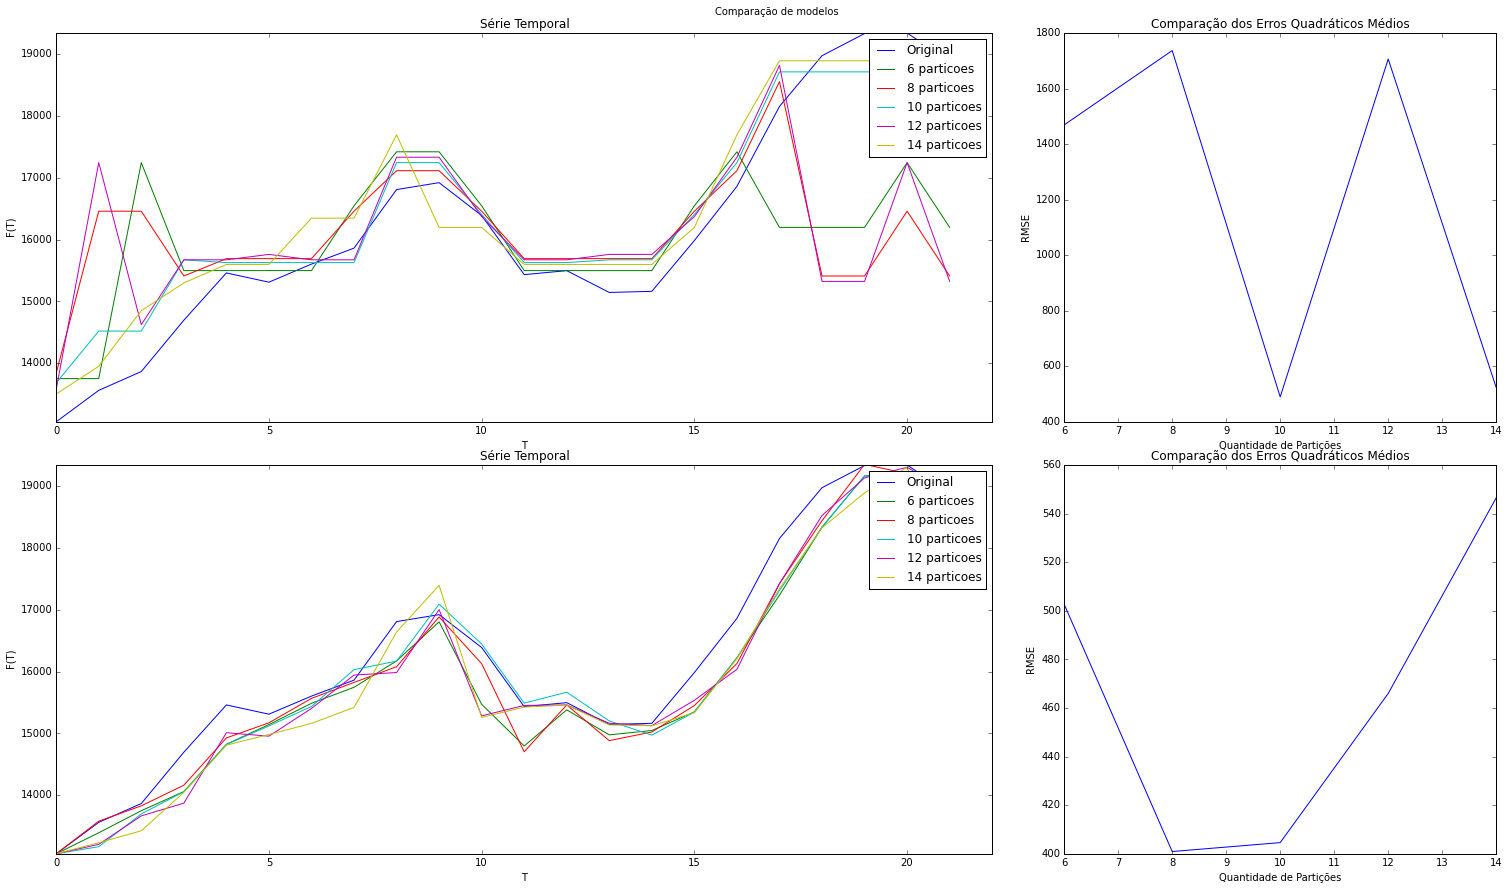

In [63]:
wfts1,wfts1p,wftsd1,wftsd1p = SelecaoSimples_MenorRMSE(enrollments,[6,8,10,12,14], WeightedFTS)

In [64]:
print(wfts1)

10 particoes:
A3 -> A4(0.166666666667),A3(0.333333333333),A5(0.5)
A9 -> A9(0.166666666667),A9(0.333333333333),A9(0.5)
A0 -> A1(1.0)
A6 -> A6(0.166666666667),A5(0.333333333333),A8(0.5)
A5 -> A4(0.333333333333),A6(0.666666666667)
A4 -> A4(0.047619047619),A4(0.0952380952381),A4(0.142857142857),A6(0.190476190476),A4(0.238095238095),A3(0.285714285714)
A1 -> A1(0.333333333333),A3(0.666666666667)
A8 -> A9(1.0)



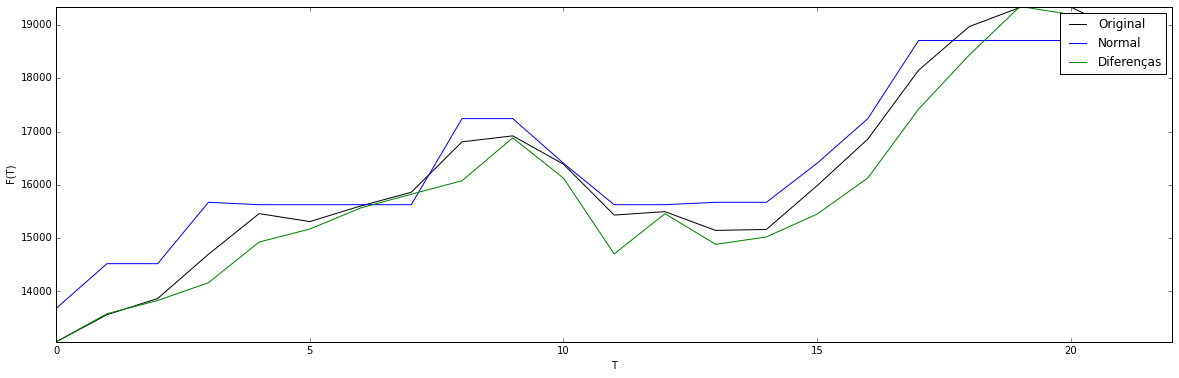

In [65]:
plotCompared(enrollments,[wfts1p,wftsd1p],["Normal","Diferenças"],'')

## WFTS - Experimento com o dataset TAIEX

Série Original
2 484.200320888
5 146.402065777
10 70.7217498116
15 126.008329065
20 40.7743964487
25 39.8003416364
30 116.142278364
35 119.577667372

Série Diferencial
2 42.7989678641
5 11.9911475285
10 17.6209415349
15 19.0861232991
20 22.4980820886
25 20.1066003388
30 22.5312507385
35 25.6560717986


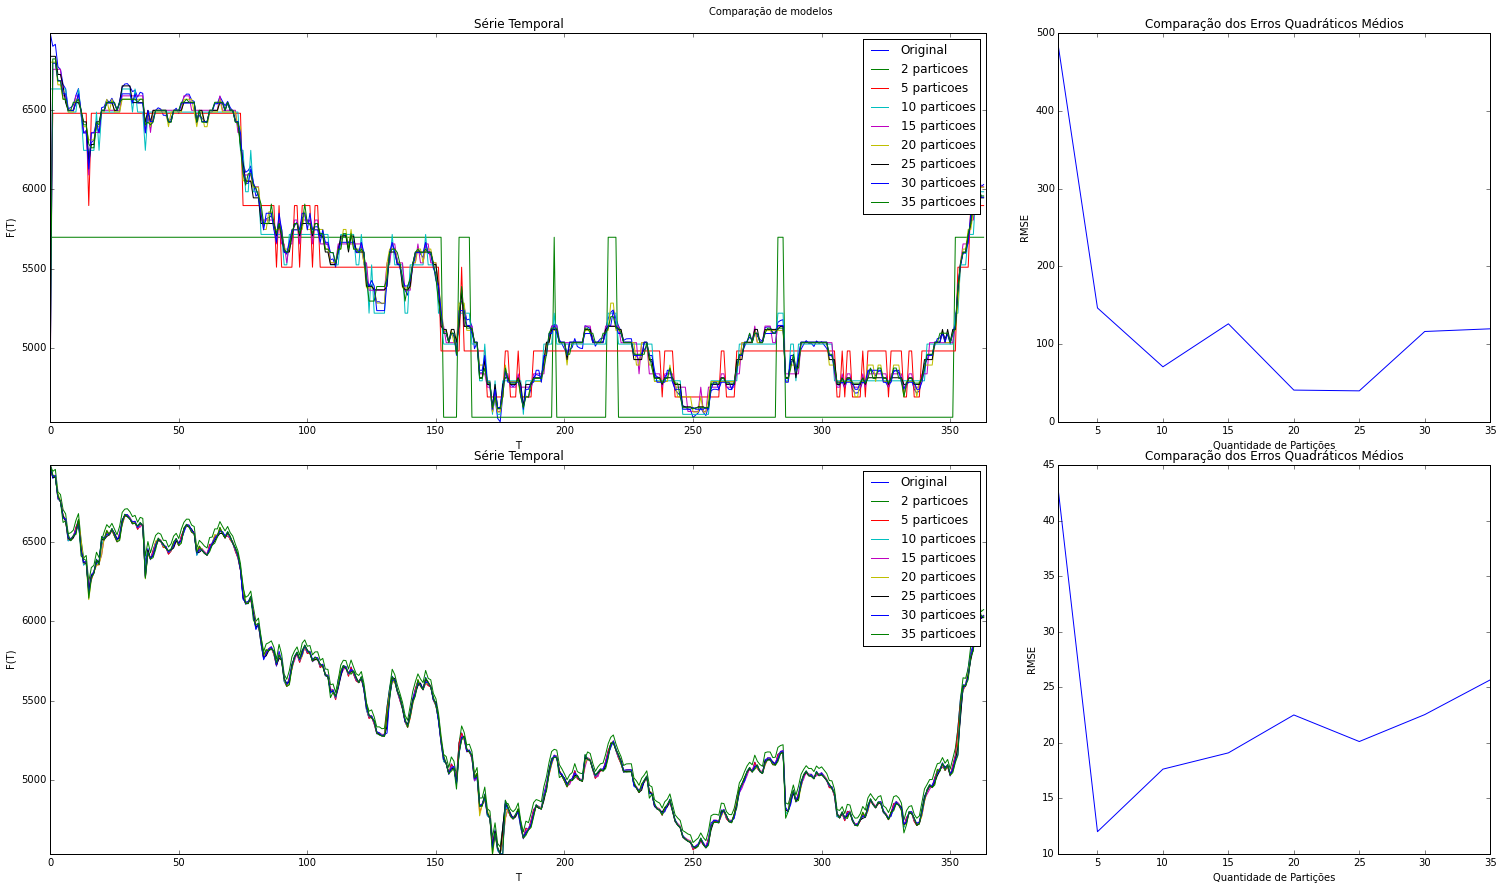

In [66]:
wfts2,wfts2p,wftsd2,wftsd2p = SelecaoSimples_MenorRMSE(taiexsample,[2,5,10,15,20,25,30,35], WeightedFTS)

In [67]:
print(wfts2)

25 particoes:
A20 -> A20(0.00246305418719),A20(0.00492610837438),A21(0.00738916256158),A19(0.00985221674877),A20(0.012315270936),A21(0.0147783251232),A20(0.0172413793103),A21(0.0197044334975),A19(0.0221674876847),A20(0.0246305418719),A20(0.0270935960591),A20(0.0295566502463),A20(0.0320197044335),A20(0.0344827586207),A19(0.0369458128079),A20(0.0394088669951),A20(0.0418719211823),A20(0.0443349753695),A21(0.0467980295567),A20(0.0492610837438),A19(0.051724137931),A20(0.0541871921182),A20(0.0566502463054),A20(0.0591133004926),A21(0.0615763546798),A21(0.064039408867),A20(0.0665024630542),A19(0.0689655172414)
A22 -> A21(0.0666666666667),A22(0.133333333333),A22(0.2),A22(0.266666666667),A21(0.333333333333)
A17 -> A18(0.333333333333),A16(0.666666666667)
A3 -> A3(0.00116144018583),A4(0.00232288037166),A3(0.00348432055749),A2(0.00464576074332),A2(0.00580720092915),A3(0.00696864111498),A3(0.00813008130081),A3(0.00929152148664),A4(0.0104529616725),A3(0.0116144018583),A3(0.0127758420441),A2(0.0139372

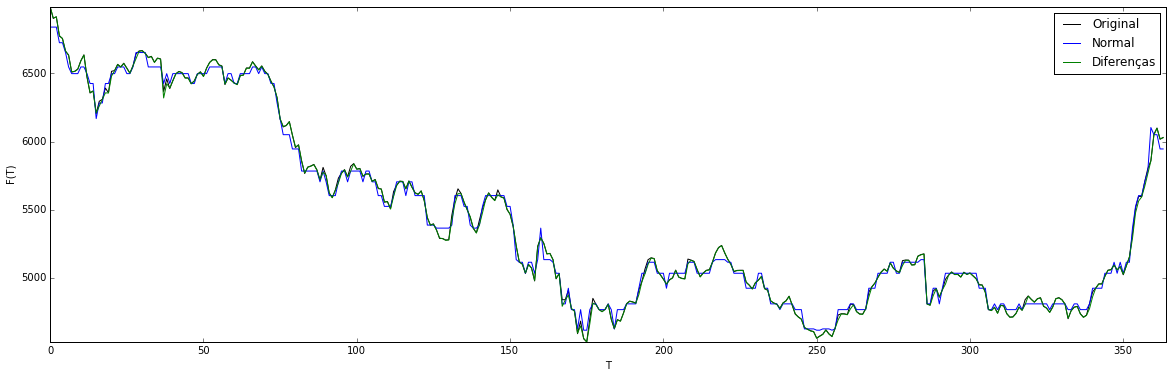

In [68]:
plotCompared(taiexsample,[wfts2p,wftsd2p],["Normal","Diferenças"],'')

# Improved Weighted Fuzzy Time Series

Os trabalhos de \cite{ismail2011enrollment} e \cite{efendi2013improved} modificam a forma como os pesos são assinalados às regras no modelo de \cite{yu2005weighted}. A diferença mais importante é que a quantidade de recorrências de cada regra é que vai determinar o seu peso, para uma regra $A_i \rightarrow A_j,A_k$, tendo $A_i \rightarrow A_j$ $n_1$ recorrências e $A_i \rightarrow A_k$ $n_2$ recorrências, o valor de cada peso será $w_k = n_k / \sum_{i=1..n} n_i$, sendo $n$ o número de regras.

## IWFTS - Código Fonte

In [69]:
class ImprovedWeightedFLRG:
	def __init__(self,premiss):
		self.premiss = premiss
		self.consequent = {}
		self.count = 0.0

	def append(self,c):
		if c not in self.consequent:
			self.consequent[c] = 1.0
		else:
			self.consequent[c] = self.consequent[c] + 1.0
		self.count = self.count + 1.0

	def weights(self):
		return np.array([ self.consequent[c]/self.count for c in self.consequent.keys() ])
        
	def __str__(self):
		tmp = self.premiss + " -> "
		tmp2 = ""
		for c in self.consequent.keys():
			if len(tmp2) > 0:
				tmp2 = tmp2 + ","
			tmp2 = tmp2 + c + "(" + str(self.consequent[c]/self.count) + ")"
		return tmp + tmp2

In [70]:
class ImprovedWeightedFTS(FTS):
	def __init__(self,name):
		super(ImprovedWeightedFTS, self).__init__(1,name)
        
	def defuzzy(self,data):
		actual = self.fuzzy(data)
		if actual["fuzzyset"] not in self.flrgs:
			return self.sets[actual["fuzzyset"]].centroid
		flrg = self.flrgs[actual["fuzzyset"]]
		mi = np.array([self.sets[s].centroid for s in flrg.consequent.keys()])
		return mi.dot( flrg.weights() )
        
	def learn(self, data, sets):
		last = {"fuzzyset":"", "membership":0.0}
		actual = {"fuzzyset":"", "membership":0.0}
		
		for s in sets:
			self.sets[s.name] = s
		
		self.flrgs = {}
		count = 1
		for inst in data:
			actual = self.fuzzy(inst)
			
			if count > self.order:
				if last["fuzzyset"] not in self.flrgs:
					self.flrgs[last["fuzzyset"]] = ImprovedWeightedFLRG(last["fuzzyset"])
			
				self.flrgs[last["fuzzyset"]].append(actual["fuzzyset"])    
			count = count + 1
			last = actual


## IWFTS - Experimento com o dataset Enrollments

Série Original
6 1223.85830842
8 1483.3701904
10 422.250747348
12 1424.75445851
14 482.697281037

Série Diferencial
6 484.842445186
8 399.931984881
10 405.181426862
12 450.146460015
14 554.053536807


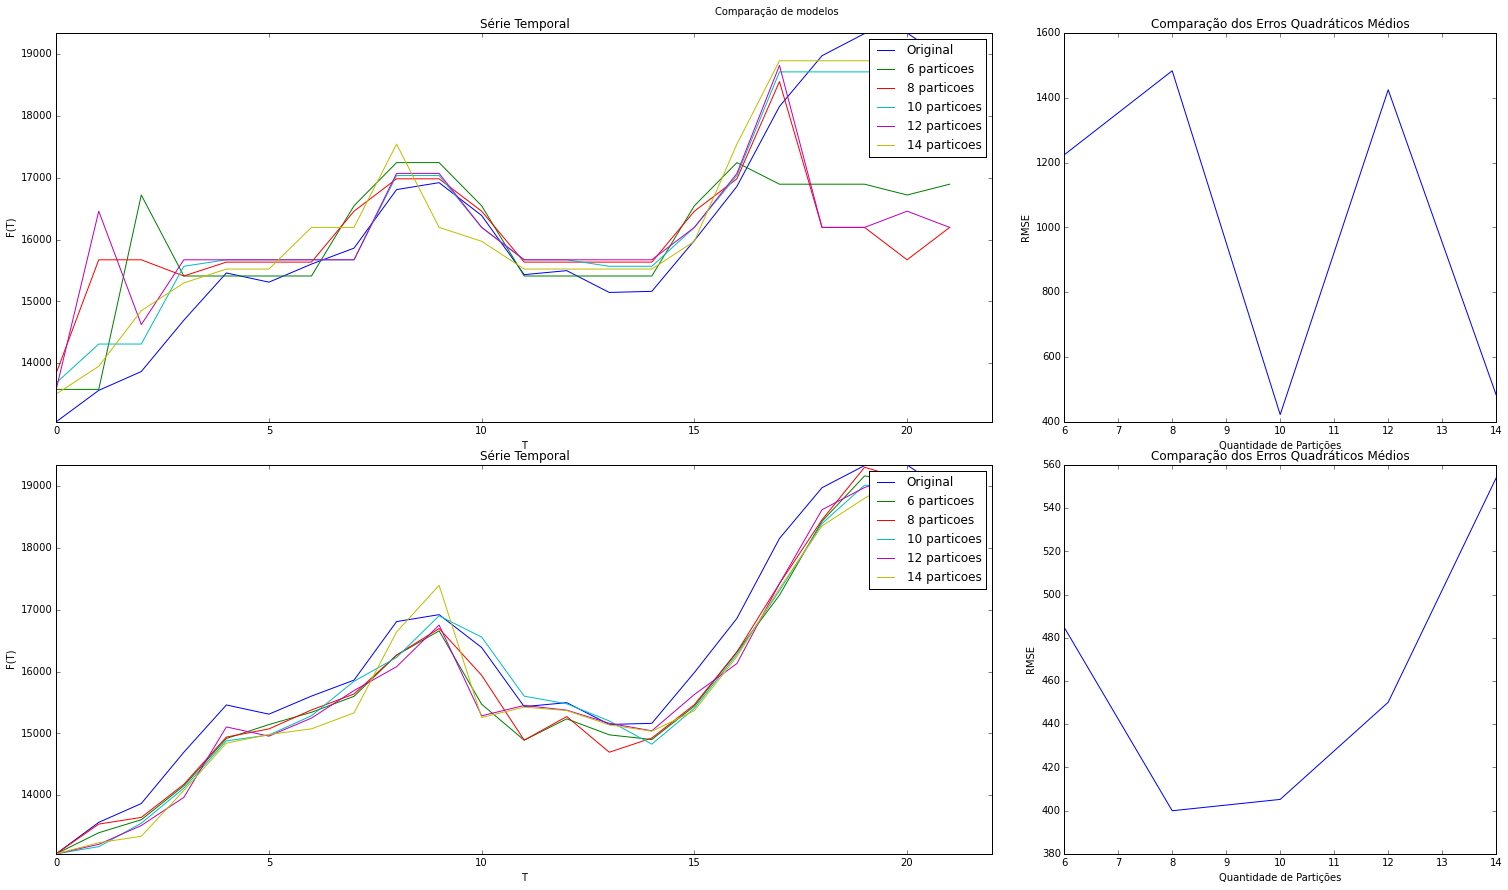

In [72]:
#fts = ImprovedWeightedFTS()
#sets = GridPartitionerTrimf(enrollments["Enrollments"],8)
#fts.learn(enrollments["Enrollments"],sets)

iwfts1,iwfts1p,iwftsd1,iwftsd1p = SelecaoSimples_MenorRMSE(enrollments,[6,8,10,12,14], ImprovedWeightedFTS)

In [73]:
print(iwfts1)

10 particoes:
A3 -> A3(0.3333333333333333),A5(0.3333333333333333),A4(0.3333333333333333)
A9 -> A9(1.0)
A0 -> A1(1.0)
A6 -> A8(0.3333333333333333),A5(0.3333333333333333),A6(0.3333333333333333)
A5 -> A6(0.5),A4(0.5)
A4 -> A6(0.16666666666666666),A4(0.6666666666666666),A3(0.16666666666666666)
A1 -> A3(0.5),A1(0.5)
A8 -> A9(1.0)



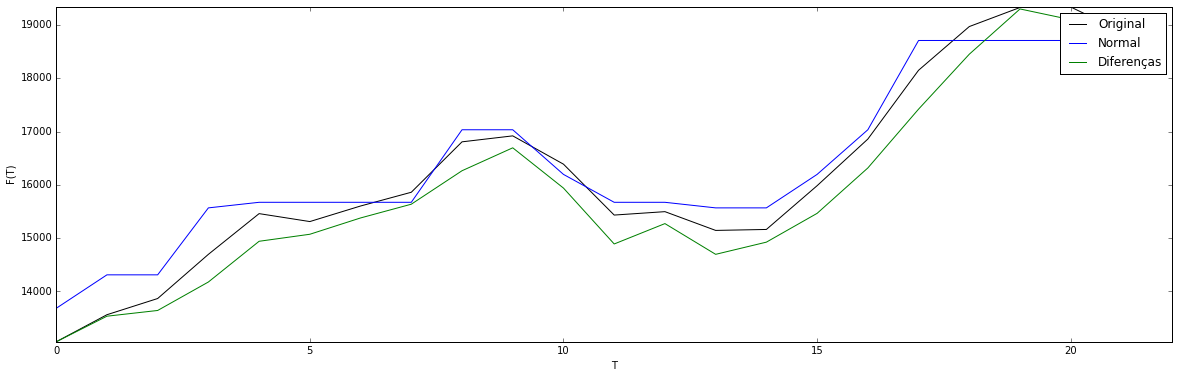

In [74]:
plotCompared(enrollments,[iwfts1p,iwftsd1p],["Normal","Diferenças"],'')


## IWFTS - Experimento com o dataset TAIEX

Série Original
2 474.835212517
5 144.447451247
10 67.1859556092
15 125.185546038
20 38.8670347789
25 35.4696240767
30 113.459871851
35 116.516228061

Série Diferencial
2 45.0094644657
5 9.94871517562
10 17.7524115375
15 17.6403001995
20 20.938321812
25 19.2775027253
30 20.5729616698
35 23.5656501451


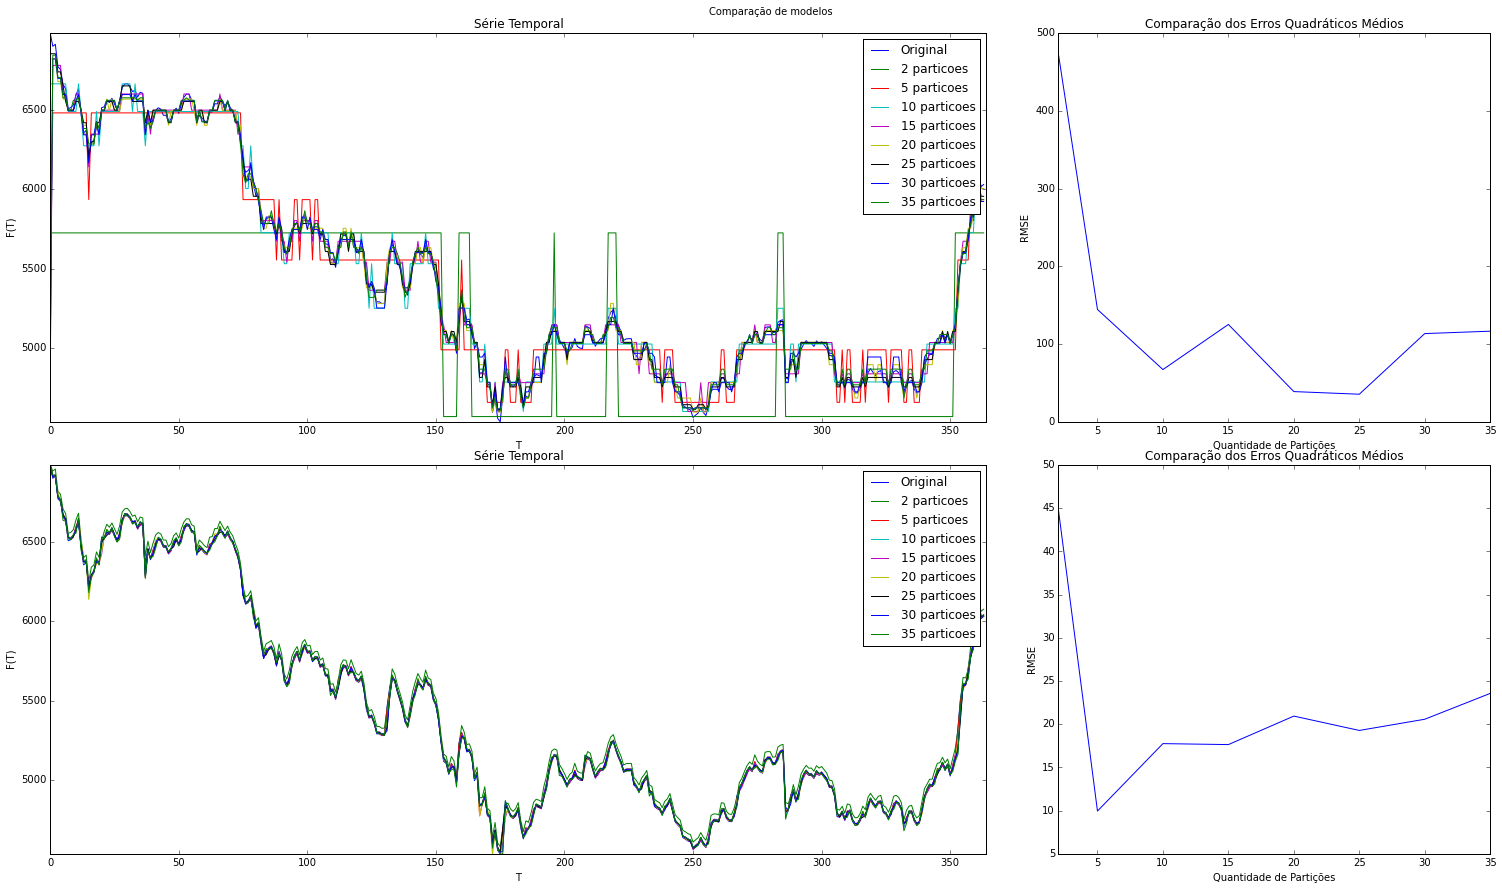

In [75]:
iwfts2,iwfts2p,iwftsd2,iwftsd2p = SelecaoSimples_MenorRMSE(taiexsample,[2,5,10,15,20,25,30,35], ImprovedWeightedFTS)

In [333]:
print(iwfts2)

5 particoes:
A0 -> A2(1.0)
A4 -> A2(0.5),A1(0.5)
A3 -> A0(0.017241379310344827),A3(0.20689655172413793),A2(0.7241379310344828),A1(0.05172413793103448)
A2 -> A0(0.0038022813688212928),A4(0.0076045627376425855),A3(0.1596958174904943),A2(0.7338403041825095),A1(0.09505703422053231)
A1 -> A3(0.10526315789473684),A2(0.6578947368421053),A1(0.23684210526315788)



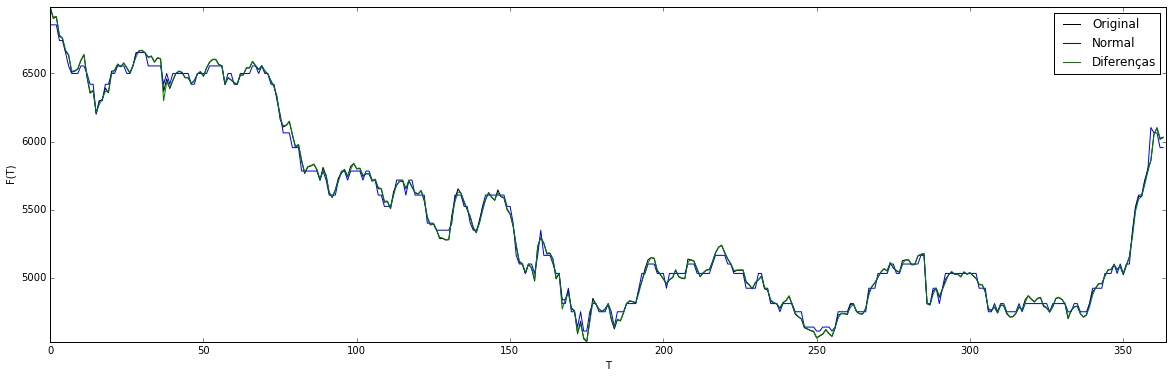

In [76]:
plotCompared(taiexsample,[iwfts2p,iwftsd2p],["Normal","Diferenças"],'')


# Exponentialy Weighted Fuzzy Time Series

O método EWFTS - \textit{Exponentialy Weighted Fuzzy Time Series}, é utilizado em \cite{sadaei2014short}, e contrasta com o crescimento linear dos pesos proposto por \cite{yu2005weighted} modificando-os por um crescimento exponencial. Dada a FLRG $A_i \rightarrow A_1,A_3,...,A_k$, a matriz $M(t) = [m_1, m_2, ...,m_k]$ dos centros de $A_1,A_3,...,A_k$ a matriz de pesos $w(t)$ será definida por um parâmetro $c$, que formará a série exponencial $c^0, c^1, ..., c^{k-1}$ normalizada. O parâmetro $c$ deve ser maior do que zero.

$$
w(t) = \left[ \frac{1}{\sum_{h=1}^k c^{h-1}},\frac{c^1}{\sum_{h=1}^k c^{h-1}},...,\frac{c^{k-1}}{\sum_{h=1}^k c^{h-1}} \right]
$$

## EWFTS - Código Fonte

In [77]:
class ExponentialyWeightedFLRG:
	def __init__(self,premiss,c):
		self.premiss = premiss
		self.consequent = []
		self.count = 0.0
		self.c = c

	def append(self,c):
		self.consequent.append(c)
		self.count = self.count + 1.0

	def weights(self):
		wei = [ self.c**k for k in np.arange(0.0,self.count,1.0)]
		tot = sum( wei )
		return np.array([ k/tot for k in wei ])
        
	def __str__(self):
		tmp = self.premiss + " -> "
		tmp2 = ""
		cc = 0
		wei = [ self.c**k for k in np.arange(0.0,self.count,1.0)]
		tot = sum( wei )
		for c in self.consequent:
			if len(tmp2) > 0:
				tmp2 = tmp2 + ","
			tmp2 = tmp2 + c + "(" + str(wei[cc]/tot) + ")"
			cc = cc + 1
		return tmp + tmp2

In [78]:
class ExponentialyWeightedFTS(FTS):
	def __init__(self,name):
		super(ExponentialyWeightedFTS, self).__init__(1,name)
        
	def defuzzy(self,data):
        
		actual = self.fuzzy(data)
        
		if actual["fuzzyset"] not in self.flrgs:
			return self.sets[actual["fuzzyset"]].centroid

		flrg = self.flrgs[actual["fuzzyset"]]

		mi = np.array([self.sets[s].centroid for s in flrg.consequent])
        
		return mi.dot( flrg.weights() )
        
	def learn(self, data, sets):
		last = {"fuzzyset":"", "membership":0.0}
		actual = {"fuzzyset":"", "membership":0.0}
		
		for s in sets:
			self.sets[s.name] = s
		
		self.flrgs = {}
		count = 1
		for inst in data:
			actual = self.fuzzy(inst)
			
			if count > self.order:
				if last["fuzzyset"] not in self.flrgs:
					self.flrgs[last["fuzzyset"]] = ExponentialyWeightedFLRG(last["fuzzyset"],2)
			
				self.flrgs[last["fuzzyset"]].append(actual["fuzzyset"])    
			count = count + 1
			last = actual


## EWFTS - Experimento com o dataset Enrollments

Série Original
6 1595.03329663
8 1774.84095057
10 519.438292024
12 1714.49422421
14 553.604229768

Série Diferencial
6 541.56601998
8 425.525684217
10 405.970793118
12 479.088818916
14 528.716293143


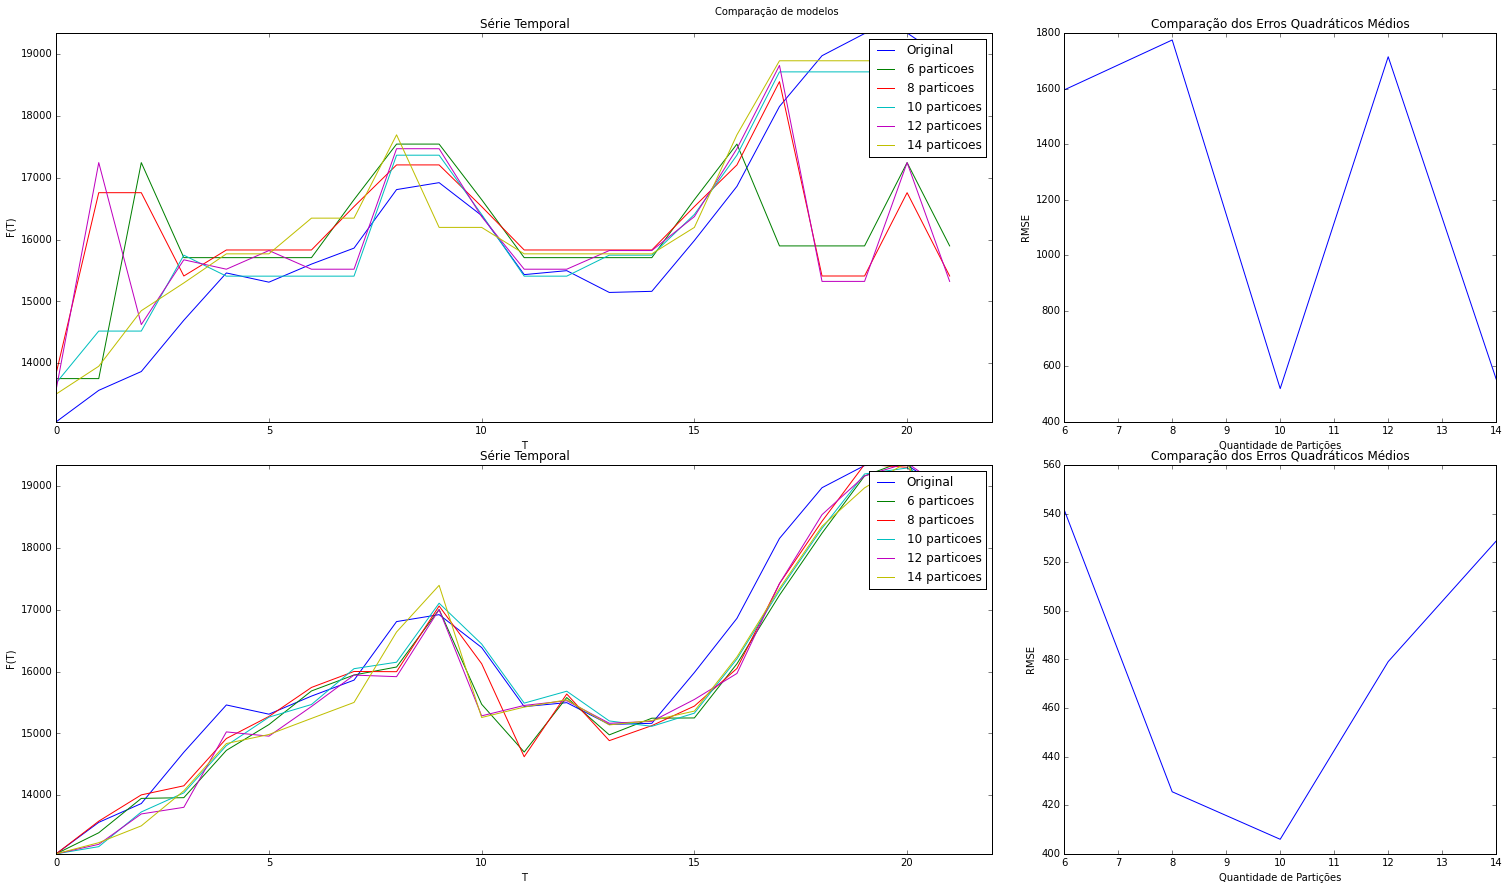

In [80]:
ewfts1,ewfts1p,ewftsd1,ewftsd1p = SelecaoSimples_MenorRMSE(enrollments,[6,8,10,12,14], ExponentialyWeightedFTS)

In [349]:
print(ewfts1)

14 particoes:
A0 -> A3(1.0)
A5 -> A6(1.0)
A3 -> A3(0.0322580645161),A9(0.0645161290323),A3(0.129032258065),A0(0.258064516129),A6(0.516129032258)
A6 -> A3(0.0666666666667),A6(0.133333333333),A2(0.266666666667),A8(0.533333333333)
A9 -> A6(1.0)
A11 -> A7(1.0)
A8 -> A5(0.0666666666667),A10(0.133333333333),A3(0.266666666667),A11(0.533333333333)
A10 -> A8(1.0)
A2 -> A7(1.0)
A7 -> A11(0.333333333333),A8(0.666666666667)



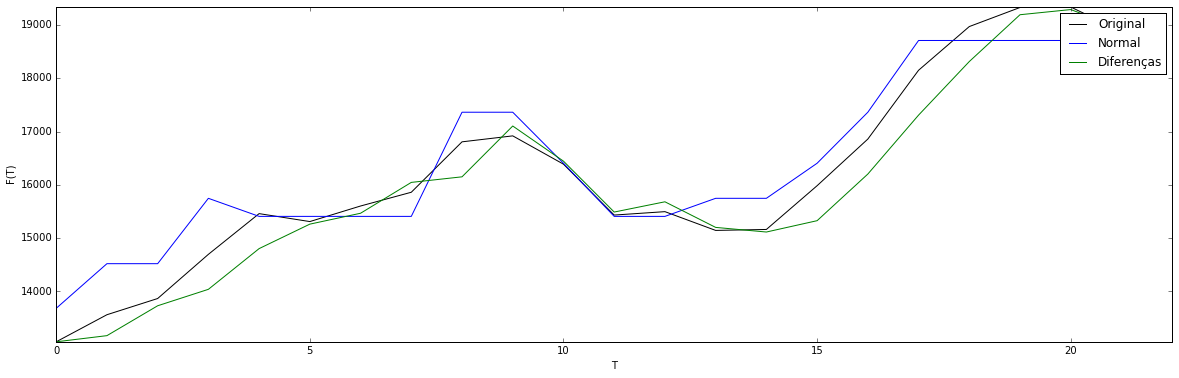

In [81]:
plotCompared(enrollments,[ewfts1p,ewftsd1p],["Normal","Diferenças"],'')

## EWFTS - Experimento com o dataset TAIEX

Série Original
2 474.835212517
5 144.447451247
10 67.1859556092
15 125.185546038
20 38.8670347789
25 35.4696240767
30 113.459871851
35 116.516228061

Série Diferencial
2 45.0094644657
5 9.94871517562
10 17.7524115375
15 17.6403001995
20 20.938321812
25 19.2775027253
30 20.5729616698
35 23.5656501451


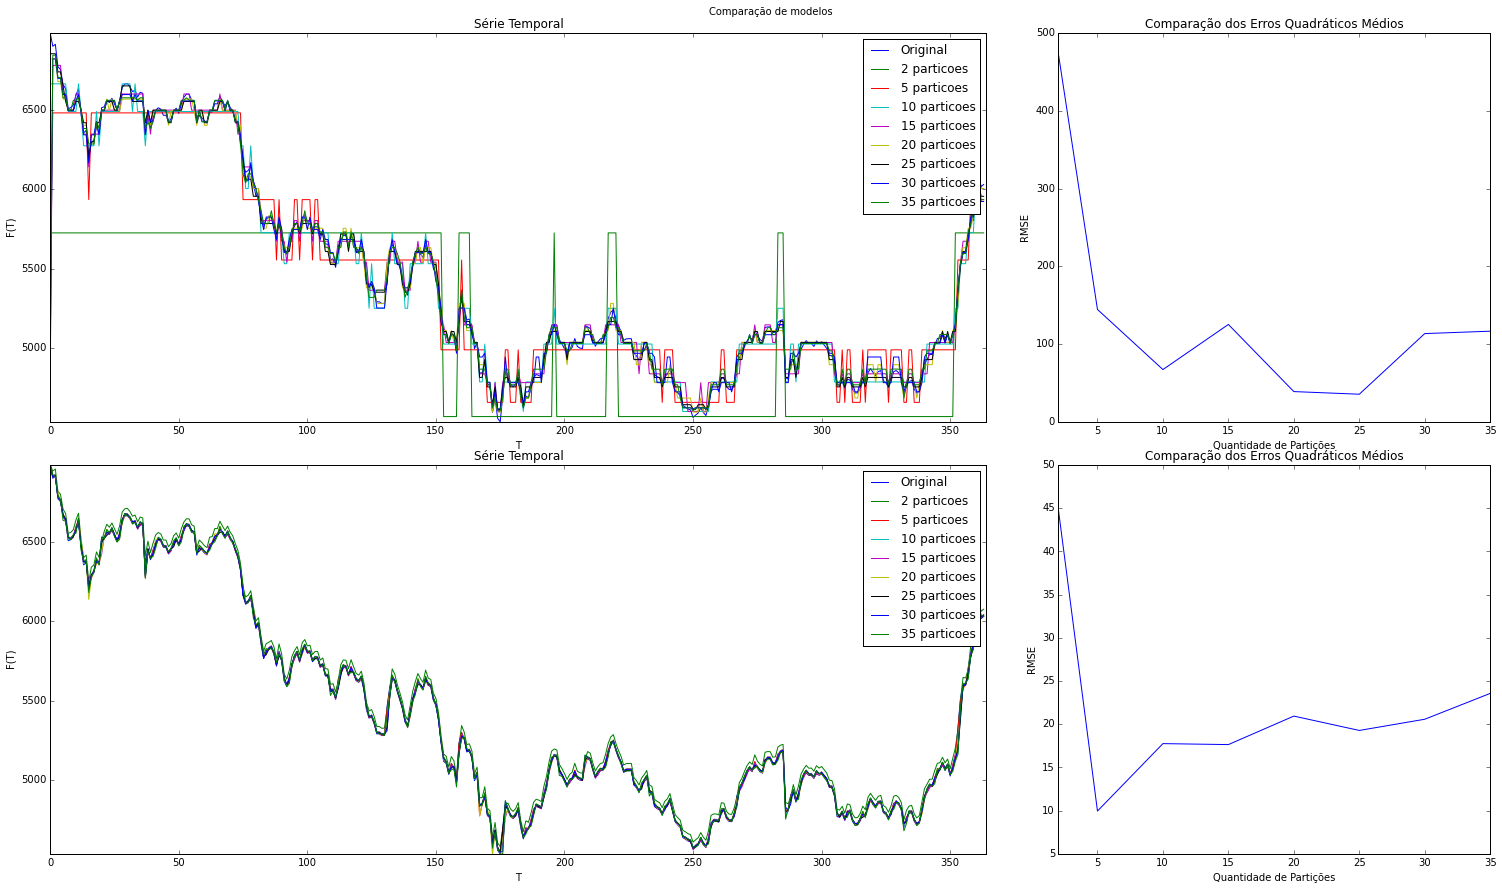

In [82]:
ewfts2,ewfts2p,ewftsd2,ewftsd2p = SelecaoSimples_MenorRMSE(taiexsample,[2,5,10,15,20,25,30,35], ImprovedWeightedFTS)

In [352]:
print(ewfts2)

5 particoes:
A0 -> A2(1.0)
A4 -> A2(0.5),A1(0.5)
A3 -> A0(0.017241379310344827),A3(0.20689655172413793),A2(0.7241379310344828),A1(0.05172413793103448)
A2 -> A0(0.0038022813688212928),A4(0.0076045627376425855),A3(0.1596958174904943),A2(0.7338403041825095),A1(0.09505703422053231)
A1 -> A3(0.10526315789473684),A2(0.6578947368421053),A1(0.23684210526315788)



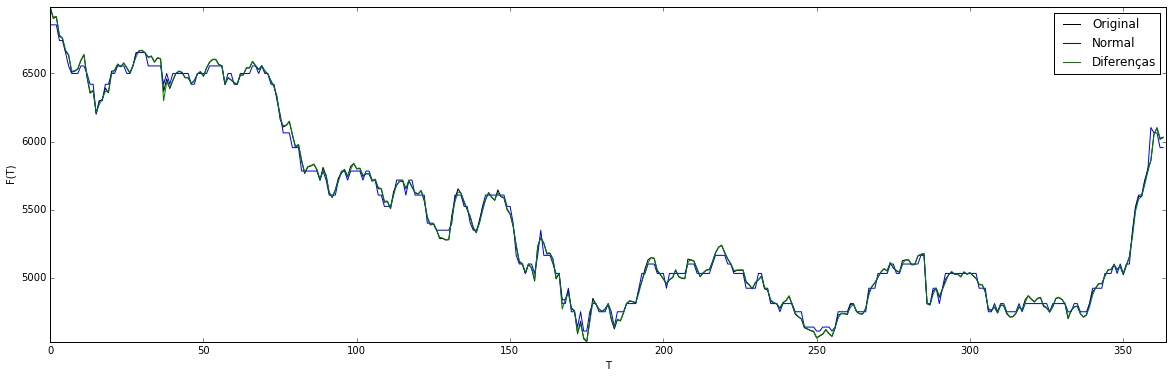

In [83]:
plotCompared(taiexsample,[ewfts2p,ewftsd2p],["Normal","Diferenças"],'')

# High Order Fuzzy Time Series

Essa implementação segue os trabalho de \cite{hwang1998handling} e \cite{chen2014high}. Esses modelos se diferenciam dos modelos de primeira ordem pelo uso de $m$ preditores em conjunto, $F(t-1),...,F(t-m)$ tal que $F(t)$ é determinado por $F(t-1)$ e $F(t-2)$ e ... e $F(t-m)$. Regras nesse estilo devem ser interpretadas como SE $F(t-1)$ E $F(t-2)$ E ... E $F(t-m)$ ENTÃO $F(t)$.

O ponto focal desse modelo é a escolha da quantidade $w$ de defasagens de tempo que serão utilizadas na predição, a chamada janela base. Com $w$ serão desenvolvidas o vetor de critérios $C(t)$ e a matriz de operação $O^w(t)$ a partir das quais se obterá a matriz das relações $R(t)$. O vetor $C(t)$ contém as pertinências 


\begin{equation}
\begin{split}
C(t) = \left[ \begin{array}{cccc}
C_1 & C_2 & ... & C_k
\end{array} \right] \\
C_i = f_{ai}( F(t-1) ) \quad 1 \leq i \leq k
\end{split}
\end{equation}

\begin{equation}
\begin{split}
O^w(t) = \left[ \begin{array}{cccc}
 O_{11} & O_{12} & ... & O_{1k} \\ 
 ... \\ 
 O_{w1} & O_{w2} & ... &O_{wk}
\end{array} \right] \\
O_{ji} = f_{ai}( F(t-j) ) \quad 1 \leq i \leq k \quad 1 \leq j \leq w
\end{split}
\end{equation}

\begin{equation}
\begin{split}
R(t) = O^w(t) \times C(t) \\
R_{ji} = O_{ij} \times C_j \quad 1 \leq i \leq k \quad 1 \leq j \leq w \\
R(t) = \left[ \begin{array}{cccc}
 R_{11} & R_{12} & ... & R_{1k} \\ 
 ... \\ 
 R_{w1} & R_{w2} & ... & R_{wk}
\end{array} \right] 
\end{split}
\end{equation}

\begin{equation}
F(t) = \left[ \begin{array}{cccc}
 \max(R_{11} & R_{21} & ... & R_{w1}) \\ 
 ... \\ 
\max(R_{1k} & R_{2k} & ... & R_{wk})
\end{array} \right] 
\end{equation}

As pertinências de $F(t)$ para os $k$ conjuntos nebulosos na fórmula. Para deffuzificar o valor a partir de dos conjuntos, utiliza-se a mesma metodologia dos modelos de primeira ordem.


## HOFTS - Código Fonte


In [147]:
class HighOrderFTS(FTS):
	def __init__(self,order,name):
		super(HighOrderFTS, self).__init__(order,name)
        
	def defuzzy(self,data,t):
		cn = np.array([0.0 for k in range(len(self.sets))])
		ow = np.array([[0.0 for k in range(len(self.sets))] for z in range(self.order-1)])
		rn = np.array([[0.0 for k in range(len(self.sets))] for z in range(self.order-1)])
		ft = np.array([0.0 for k in range(len(self.sets))])

		for s in range(len(self.sets)):
			cn[s] = self.sets[s].membership(data[t]) 
			for w in range(self.order-1):
				ow[w,s] = self.sets[s].membership(data[t-w]) 
				rn[w,s] = ow[w,s] * cn[s]
				ft[s] = max(ft[s],rn[w,s])
		mft =  max(ft)
		out = 0.0
		count = 0.0
		for s in range(len(self.sets)):
			if ft[s] == mft:
				out = out + self.sets[s].centroid
				count = count + 1.0
		return out / count


	def learn(self, data, sets):
		self.sets = sets
    
	def predict(self,data,t):
		return self.defuzzy(data,t)

	def predictDiff(self,data,t):
		return data[t] + self.defuzzy(diferencas(data),t)


In [163]:
def HOSelecaoSimples_MenorRMSE(original,parameters,orders):
	ret = []
	errors = np.array([[0 for k in range(len(parameters))] for kk in range(len(orders))])
	predicted_best = []
	print("Série Original")
	fig = plt.figure(figsize=[20,12])
	fig.suptitle("Comparação de modelos ")
	ax0 = fig.add_axes([0, 0.5, 0.6, 0.45]) #left, bottom, width, height
	ax0.set_xlim([0,len(original)])
	ax0.set_ylim([min(original),max(original)])
	ax0.set_title('Série Temporal')
	ax0.set_ylabel('F(T)')
	ax0.set_xlabel('T')
	ax0.plot(original,label="Original")
	min_rmse = 100000.0
	best = None
	pc = 0
	for p in parameters:
		oc = 0
		for o in orders:
			sets = GridPartitionerTrimf(original,p)
			fts = HighOrderFTS(o,"k = " + str(p)+ " w = " + str(o))
			fts.learn(original,sets)
			predicted = [fts.predict(original, xx) for xx in range(o,len(original))]
			error = rmse(np.array(predicted),np.array(original[o:]))
			for kk in range(o):
				predicted.insert(0,None)
			ax0.plot(predicted,label=fts.name)
			print(o,p,error)
			errors[oc,pc] = error
			if error < min_rmse:
				min_rmse = error
				best = fts
				predicted_best = predicted
			oc = oc + 1
		pc = pc + 1
		handles0, labels0 = ax0.get_legend_handles_labels()
	ax0.legend(handles0, labels0)
	ax1 = Axes3D(fig, rect=[0.6, 0.5, 0.45, 0.45], elev=30, azim=144)
	ax1.set_title('Comparação dos Erros Quadráticos Médios por tamanho da janela')
	ax1.set_ylabel('RMSE')
	ax1.set_xlabel('Quantidade de Partições')
	ax1.set_zlabel('W')
	X,Y = np.meshgrid(parameters,orders)
	surf = ax1.plot_surface(X, Y, errors)
	ret.append(best)
	ret.append(predicted_best)

    # Modelo diferencial
	print("\nSérie Diferencial")
	errors = np.array([[0 for k in range(len(parameters))] for kk in range(len(orders))])
	predictedd_best = []
	ax2 = fig.add_axes([0, 0, 0.6, 0.45]) #left, bottom, width, height
	ax2.set_xlim([0,len(original)])
	ax2.set_ylim([min(original),max(original)])
	ax2.set_title('Série Temporal')
	ax2.set_ylabel('F(T)')
	ax2.set_xlabel('T')
	ax2.plot(original,label="Original")
	min_rmse = 100000.0
	bestd = None
	pc = 0
	for p in parameters:
		oc = 0
		for o in orders:
			sets = GridPartitionerTrimf(diferencas(original),p)
			fts = HighOrderFTS(o,"k = " + str(p)+ " w = " + str(o))
			fts.learn(original,sets)
			predicted = [fts.predictDiff(original, xx) for xx in range(o,len(original))]
			error = rmse(np.array(predicted),np.array(original[o:]))
			for kk in range(o):
				predicted.insert(0,None)
			ax2.plot(predicted,label=fts.name)
			print(o,p,error)
			errors[oc,pc] = error
			if error < min_rmse:
				min_rmse = error
				bestd = fts
				predictedd_best = predicted
			oc = oc + 1
		pc = pc + 1
	handles0, labels0 = ax2.get_legend_handles_labels()
	ax2.legend(handles0, labels0)
	ax3 = Axes3D(fig, rect=[0.6, 0.0, 0.45, 0.45], elev=30, azim=144)
	ax3.set_title('Comparação dos Erros Quadráticos Médios')
	ax3.set_ylabel('RMSE')
	ax3.set_xlabel('Quantidade de Partições')
	ax3.set_zlabel('W')
	X,Y = np.meshgrid(parameters,orders)
	surf = ax3.plot_surface(X, Y, errors,  rstride=4, cstride=4, antialiased=True)
	ret.append(bestd)
	ret.append(predictedd_best)
	return ret

## HOFTS - Experimento com o dataset Enrollments

Série Original
2 4 1135.40636586
3 4 1155.361058
4 4 1186.9043316
5 4 1204.42722078
6 4 1229.61003886
2 8 835.295995909
3 8 856.973636305
4 8 883.150995823
5 8 908.676371016
6 8 936.310132936
2 10 259.279733107
3 10 262.652177443
4 10 263.670269676
5 10 270.05177717
6 10 270.858487037
2 12 784.234389787
3 12 802.799265809
4 12 824.630432797
5 12 846.971076057
6 12 872.097903854

Série Diferencial
2 4 543.426170813
3 4 556.209732428
4 4 544.96920466
5 4 525.080235465
6 4 539.608267201
2 8 582.100861777
3 8 574.005751536
4 8 564.87514061
5 8 553.669066088
6 8 570.01249044
2 10 597.680525448
3 10 606.556520992
4 10 590.747088675
5 10 572.561374568
6 10 590.013104198
2 12 590.671770635
3 12 604.789602933
4 12 597.098008077
5 12 589.773383766
6 12 605.732072937


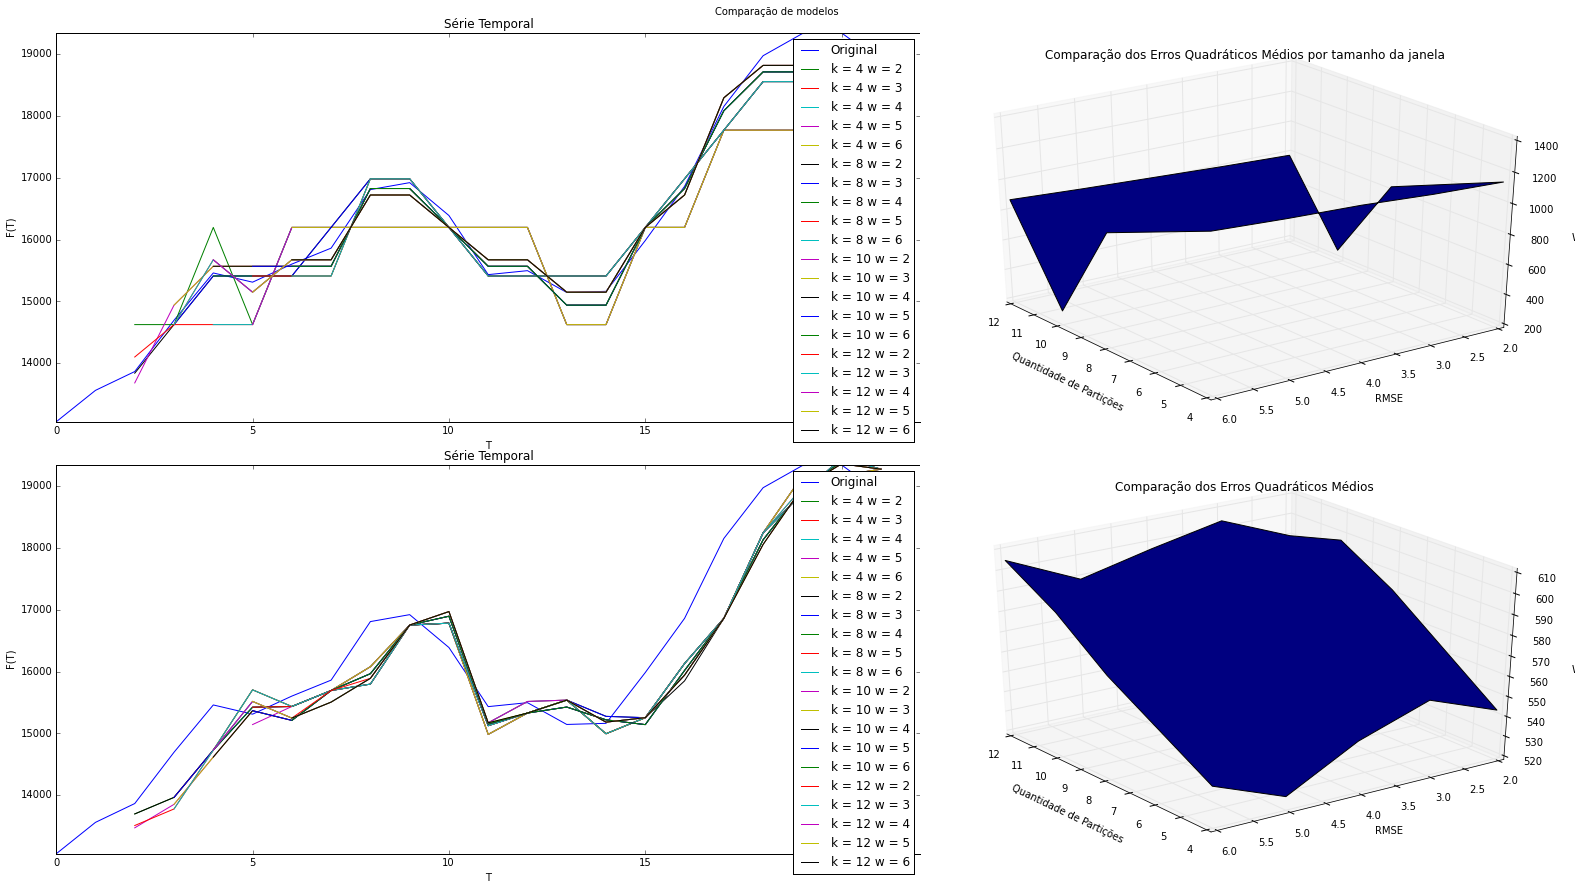

In [164]:
hofts1,hofts1p,hoftsd1,hoftsd1p = HOSelecaoSimples_MenorRMSE(enrollments,[4,8,10,12],[2,3,4,5,6])

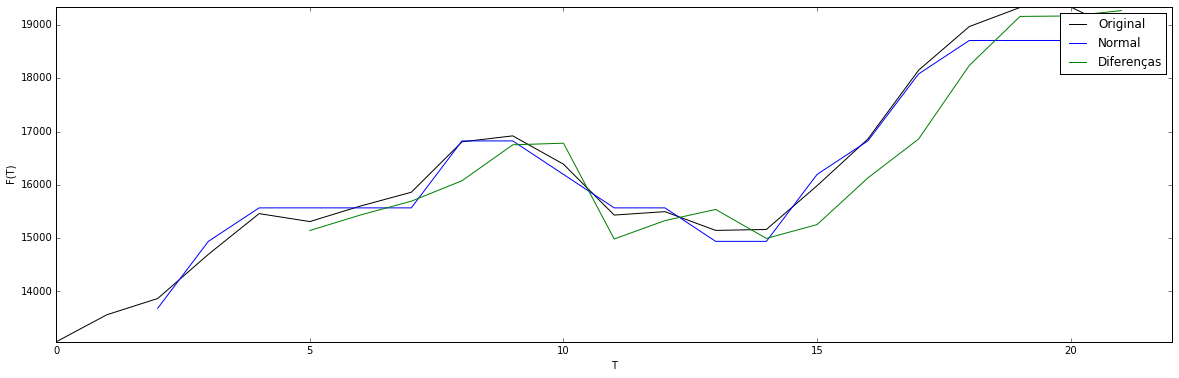

In [165]:
plotCompared(enrollments,[hofts1p,hoftsd1p],["Normal","Diferenças"],'')

## EWFTS - Experimento com o dataset TAIEX

Série Original
2 5 140.282240239
3 5 139.18510974
4 5 140.048728835
5 5 141.013652171
6 5 141.691217976
2 10 66.3983976278
3 10 67.0930064647
4 10 68.3137918349
5 10 68.6535832072
6 10 68.7625613769
2 15 47.131290739
3 15 47.9201949065
4 15 48.2244921293
5 15 48.3943235281
6 15 48.2094561632
2 20 35.1197833816
3 20 35.837699373
4 20 36.1602712268
5 20 36.7769911058
6 20 36.5690152046
2 25 27.5555360738
3 25 28.2039986706
4 25 28.4815272269
5 25 28.4895365359
6 25 28.5229062818

Série Diferencial
2 5 68.125973516
3 5 64.2585003621
4 5 62.3167684751
5 5 60.6929960204
6 5 60.457940196
2 10 66.2319736093
3 10 66.5780580928
4 10 65.7008498451
5 10 65.4640121009
6 10 64.5634694559
2 15 67.0905308797
3 15 67.0140081027
4 15 66.2440152146
5 15 65.9744605126
6 15 66.138110958
2 20 67.6874284624
3 20 67.8474780426
4 20 67.6387653686
5 20 67.5218085451
6 20 67.500320084
2 25 65.0498688519
3 25 65.0546984771
4 25 64.675967141
5 25 64.6064745513
6 25 64.8352869678


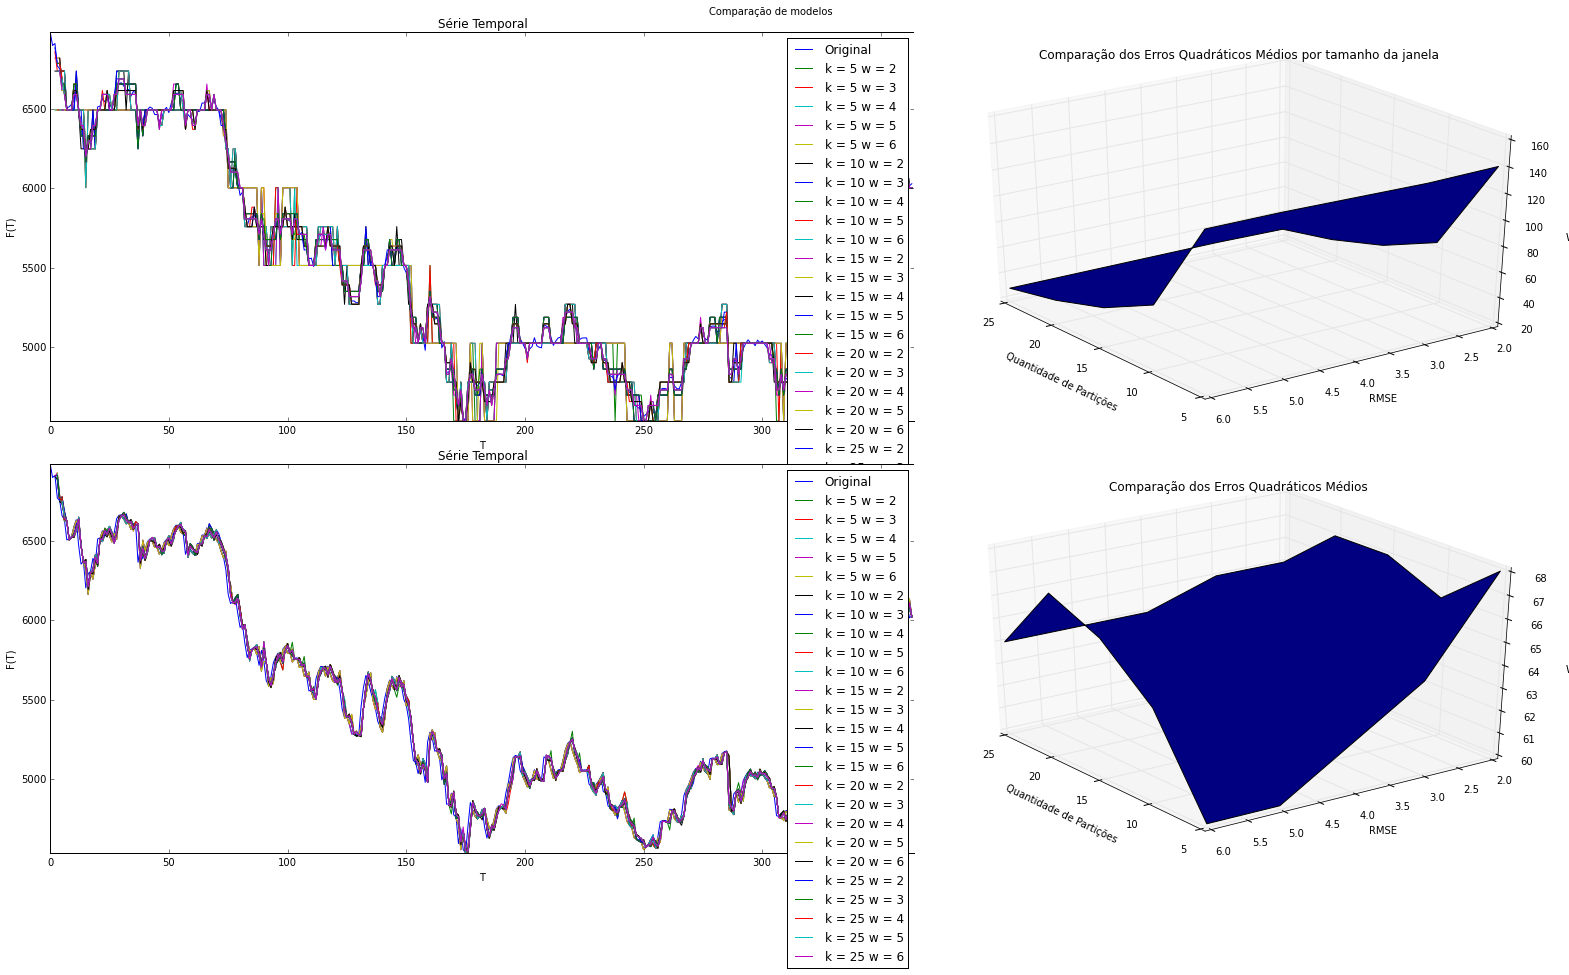

In [167]:
hofts2,hofts2p,hoftsd2,hoftsd2p = HOSelecaoSimples_MenorRMSE(taiexsample,[5,10,15,20,25],[2,3,4,5,6])

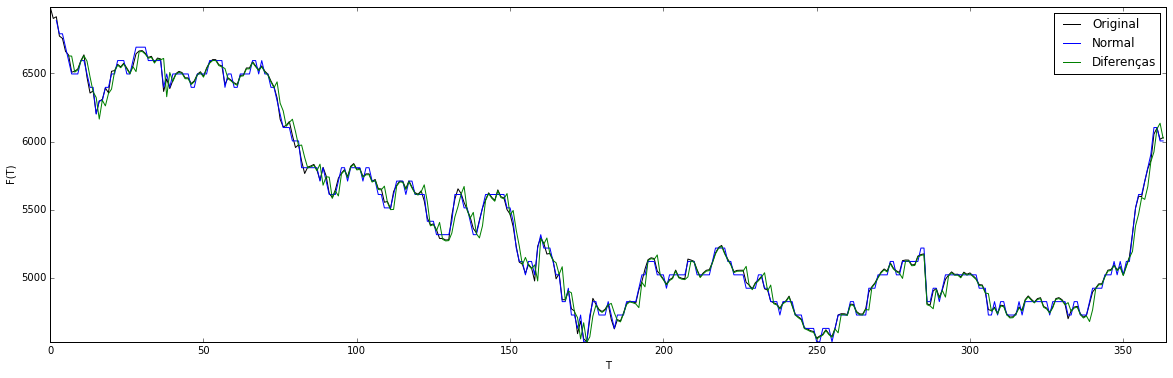

In [168]:
plotCompared(taiexsample,[hofts2p,hoftsd2p],["Normal","Diferenças"],'')

# References

(<a id="cit-song1993fuzzy" href="#call-song1993fuzzy">Song and Chissom, 1993</a>) Song Qiang and Chissom Brad S, ``_Fuzzy time series and its models_'', Fuzzy sets and systems, vol. 54, number 3, pp. 269--277,  1993.

(<a id="cit-chen1996forecasting" href="#call-chen1996forecasting">Chen, 1996</a>) Chen Shyi-Ming, ``_Forecasting enrollments based on fuzzy time series_'', Fuzzy sets and systems, vol. 81, number 3, pp. 311--319,  1996.

(<a id="cit-ismail2011enrollment" href="#call-ismail2011enrollment">Ismail and Efendi, 2011</a>) Ismail Zuhaimy and Efendi R, ``_Enrollment forecasting based on modified weight fuzzy time series_'', Journal of Artificial Intelligence, vol. 4, number 1, pp. 110--118,  2011.

(<a id="cit-efendi2013improved" href="#call-efendi2013improved">Efendi, Ismail <em>et al.</em>, 2013</a>) Efendi Riswan, Ismail Zuhaimy and Deris Mustafa Mat, ``_IMPROVED WEIGHT FUZZY TIME SERIES AS USED IN THE EXCHANGE RATES FORECASTING OF US DOLLAR TO RINGGIT MALAYSIA_'', International Journal of Computational Intelligence and Applications, vol. 12, number 01, pp. 1350005,  2013.

(<a id="cit-yu2005weighted" href="#call-yu2005weighted">Yu, 2005</a>) Yu Hui-Kuang, ``_Weighted fuzzy time series models for TAIEX forecasting_'', Physica A: Statistical Mechanics and its Applications, vol. 349, number 3, pp. 609--624,  2005.

(<a id="cit-sadaei2014short" href="#call-sadaei2014short">Sadaei, Enayatifar <em>et al.</em>, 2014</a>) Sadaei Hossein Javedani, Enayatifar Rasul, Abdullah Abdul Hanan <em>et al.</em>, ``_Short-term load forecasting using a hybrid model with a refined exponentially weighted fuzzy time series and an improved harmony search_'', International Journal of Electrical Power \& Energy Systems, vol. 62, number , pp. 118--129,  2014.

(<a id="cit-hwang1998handling" href="#call-hwang1998handling">Hwang, Chen <em>et al.</em>, 1998</a>) Hwang Jeng-Ren, Chen Shyi-Ming and Lee Chia-Hoang, ``_Handling forecasting problems using fuzzy time series_'', Fuzzy sets and systems, vol. 100, number 1, pp. 217--228,  1998.

(<a id="cit-chen2014high" href="#call-chen2014high">Chen, 2014</a>) Chen Mu-Yen, ``_A high-order fuzzy time series forecasting model for internet stock trading_'', Future Generation Computer Systems, vol. 37, number , pp. 461--467,  2014.

